<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc" style="margin-top: 1em;"><ul class="toc-item"><li><span><a href="#Filtering" data-toc-modified-id="Filtering-1">Filtering</a></span><ul class="toc-item"><li><span><a href="#Filter-out-dangling-ends-and-self-circles" data-toc-modified-id="Filter-out-dangling-ends-and-self-circles-1.1">Filter out dangling ends and self-circles</a></span></li><li><span><a href="#Apply-filters-on-the-data" data-toc-modified-id="Apply-filters-on-the-data-1.2">Apply filters on the data</a></span><ul class="toc-item"><li><span><a href="#Evaluate-changes" data-toc-modified-id="Evaluate-changes-1.2.1">Evaluate changes</a></span></li></ul></li><li><span><a href="#Save-to-BAM" data-toc-modified-id="Save-to-BAM-1.3">Save to BAM</a></span></li></ul></li></ul></div>

# Filtering

![Filters](images/Filters.jpeg)

Pairs of mapped read-ends are filtered in order to keep only valid pairs. The filters available in TADbit are these one:
   1. __self-circle__: read-ends are coming from a single restriction enzymes (RE) fragment and point towards the outside (`—-<===—===>—`)
   2. __dangling-end__: read-ends are coming from a single RE fragment and point towards the inside (`—-===>—<===—`)
   3. __error__: read-ends are coming from a single RE fragment and point in the same direction
   4. __extra dangling-end__: read-ends are coming from different RE fragments but are close enough that the probability that they belong from a single fragment is high (distance between mapped ends < max_molecule length),  also they point to the inside (like dangling-ends)
   5. too close from restriction enzymes REs (or _semi-dangling-end_): start position of one of the read-end is too close (5 bp by default) from RE cutting site. This filter is skipped in case read fragments are involved in a multiple contact. This filter may be too conservative for 4 bp cutter REs (usually not applied).
   6. too short: remove reads coming from small restriction less than 75 bp (sequenced length) because they are comparable to the read length and may also belong to any of the two neighboring fragments.
   7. too large: remove reads coming from large restriction fragments (default: 100 Kb, P < 10-5 to occur in a randomized genome) as they likely represent poorly assembled or repeated regions
   8. over-represented: reads coming from the top 0.5% most frequently detected restriction fragments, they may be prone to PCR artifacts or represent fragile regions of the genome or genome assembly errors
   9. __duplicated__: the combination of the start positions, mapped length and strands of the read-ends are identical -> PCR artifact (only keep one copy)
   10. __random breaks__: start position of one of the read is too far (more than min_dist_to_re) from RE cutting site. Most probably non-canonical enzyme activity or random physical breakage of the chromatin.

In [1]:
cell = 'mouse_B'  # or mouse_PSC
rep = 'rep1'  # or rep2

## Filter out dangling ends and self-circles

In [2]:
from pytadbit.mapping.filter import filter_reads

The `max_molecule_length` parameter used to filter-out pseudo-dangling-ends can be extracted from the previous section in the computation of insert size.

The `min_distance_to_re`, that affects the detection of random breaks, should be a bit larger in order to contain almost all the fragments.

In [3]:
# this will last ~10 minutes
masked = filter_reads(
    'results/fragment/{0}_{1}/03_filtering/reads12_{0}_{1}.tsv'.format(cell, rep), 
    max_molecule_length=750, over_represented=0.005, max_frag_size=100000, 
    min_frag_size=50, re_proximity=5, min_dist_to_re=1000)

Filtered reads (and percentage of total):

                   Mapped both  :   87,862,102 (100.00%)
  -----------------------------------------------------
   1-               self-circle :       87,761 (  0.10%)
   2-              dangling-end :    4,813,620 (  5.48%)
   3-                     error :       18,165 (  0.02%)
   4-        extra dangling-end :   12,933,038 ( 14.72%)
   5-        too close from RES :   21,372,275 ( 24.32%)
   6-                 too short :    3,628,579 (  4.13%)
   7-                 too large :        1,256 (  0.00%)
   8-          over-represented :    2,693,107 (  3.07%)
   9-                duplicated :    1,605,185 (  1.83%)
  10-             random breaks :      308,512 (  0.35%)


This generates a dictionary with the different filters and the reads affected by each.

## Apply filters on the data

In [4]:
from pytadbit.mapping.filter import apply_filter

apply_filter('results/fragment/{0}_{1}/03_filtering/reads12_{0}_{1}.tsv'.format(cell, rep), 
             'results/fragment/{0}_{1}/03_filtering/valid_reads12_{0}_{1}.tsv'.format(cell, rep), masked, 
             filters=[1, 2, 3, 4, 6, 7, 9, 10])

    saving to file 66,612,427 reads without.


66612427

### Evaluate changes

/home/fransua/.miniconda2/lib/python2.7/site-packages/matplotlib/axes/_base.py:3477: UserWarning: Attempted to set non-positive ylimits for log-scale axis; invalid limits will be ignored.
  'Attempted to set non-positive ylimits for log-scale axis; '
/home/fransua/.miniconda2/lib/python2.7/site-packages/matplotlib/axes/_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


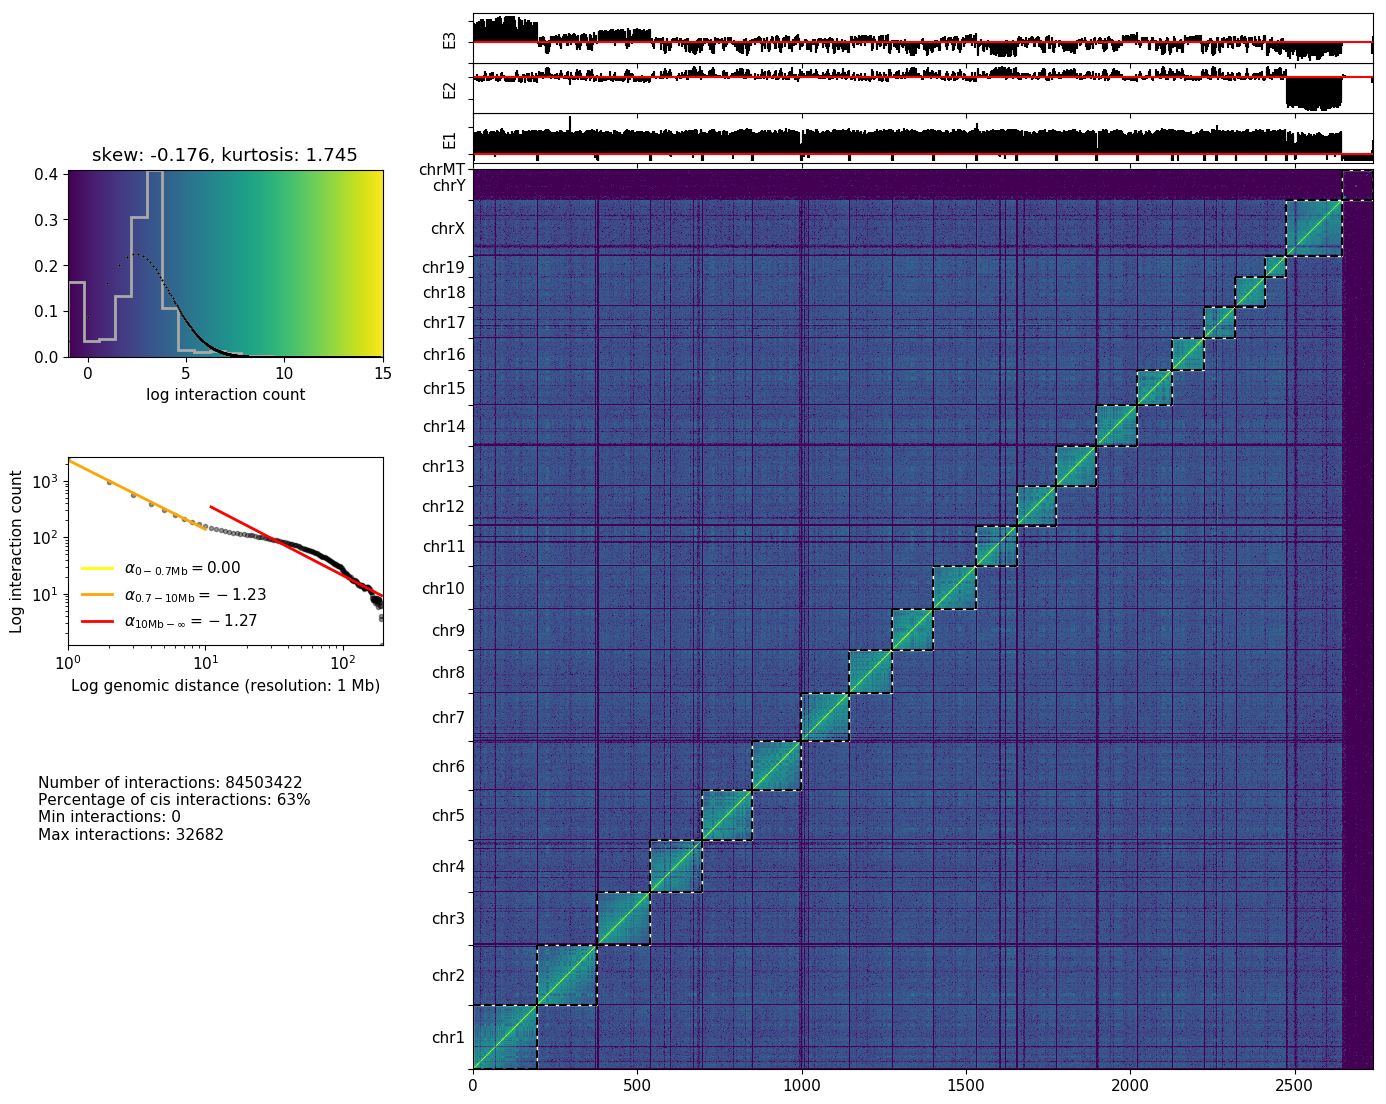

In [5]:
from pytadbit.mapping.analyze import hic_map

hic_map('results/fragment/{0}_{1}/03_filtering/valid_reads12_{0}_{1}.tsv'.format(cell, rep), 
        resolution=1000000, show=True, cmap='viridis')

Zoom to a single chromosome or a region:

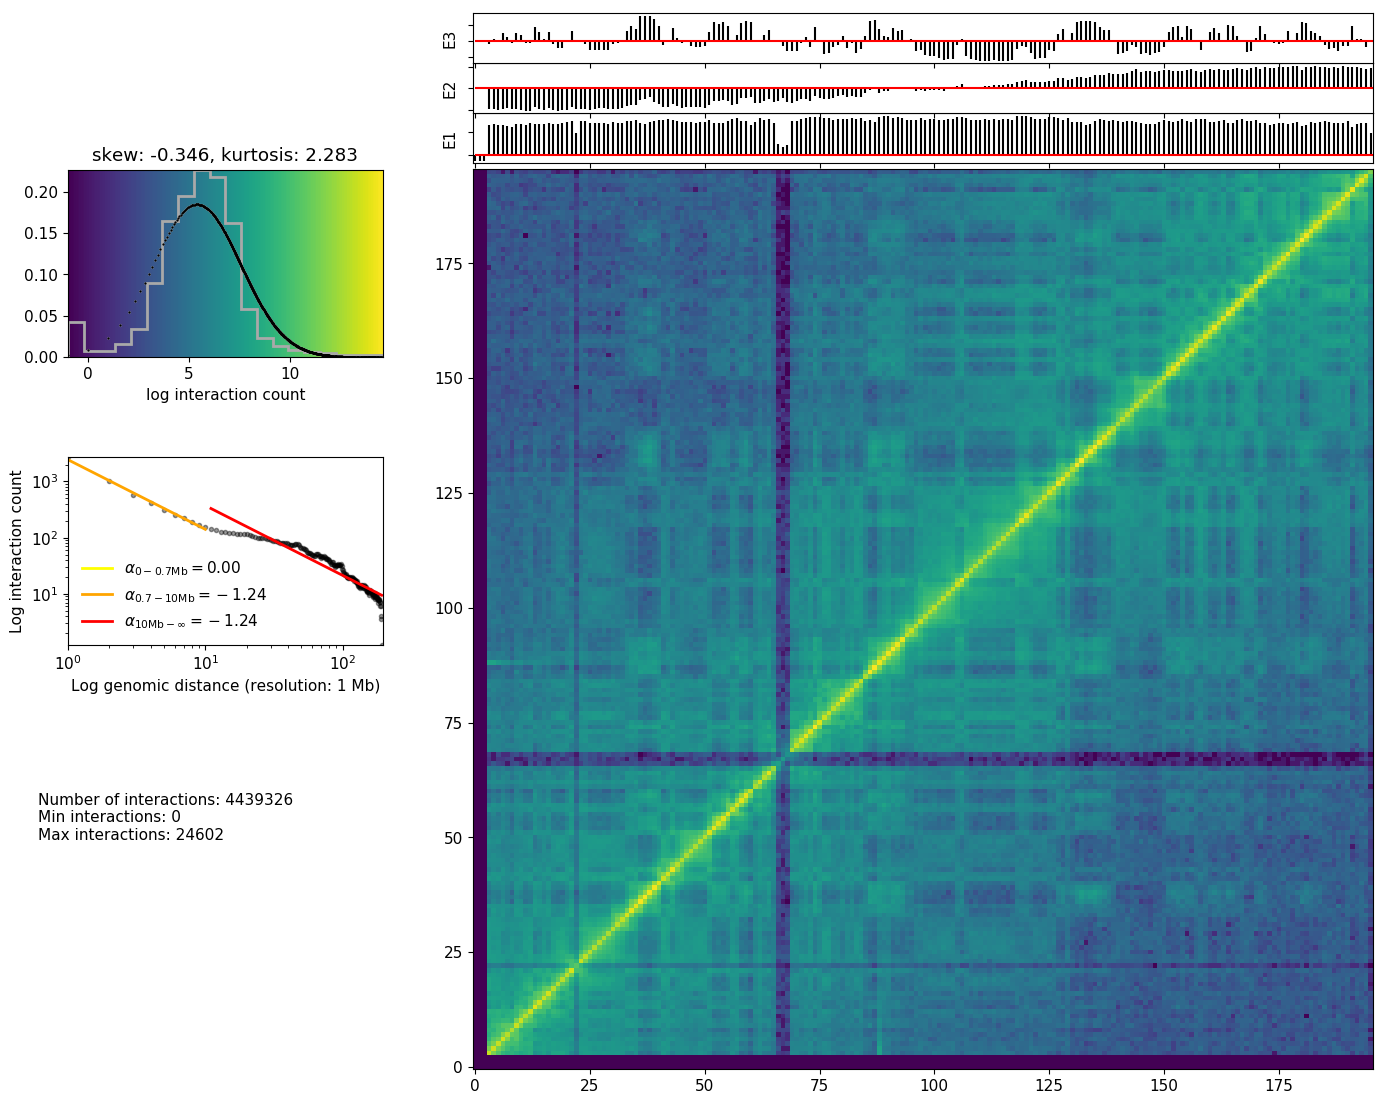

In [6]:
hic_map('results/fragment/{0}_{1}/03_filtering/valid_reads12_{0}_{1}.tsv'.format(cell, rep), 
        resolution=1000000, show=True, focus='chr1', cmap='viridis')

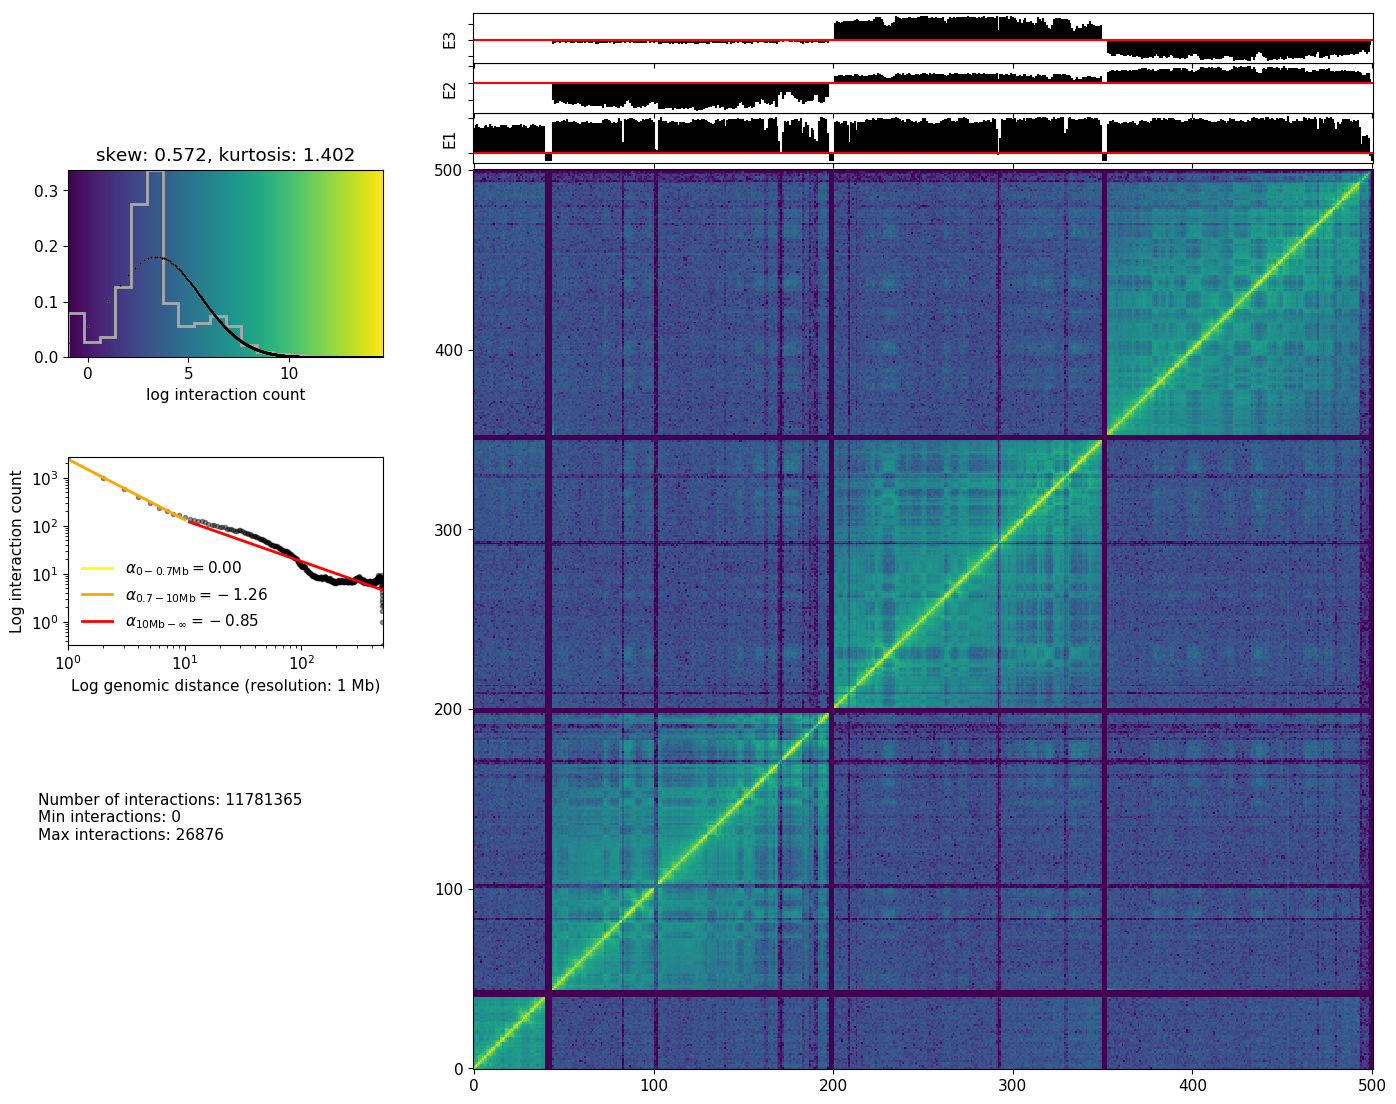

In [7]:
hic_map('results/fragment/{0}_{1}/03_filtering/valid_reads12_{0}_{1}.tsv'.format(cell, rep), 
        resolution=1000000, show=True, focus=(500, 1000), cmap='viridis')

## Save to BAM

Working with TSV (tab separated value file format) files is very slow. For the next part of the tutorial we will be using BAM files, which are compressed and indexed.

The fields we use in TADbit (not the conventional ones) are the following:
 - read ID (same as in the original FASTQ file)
 - flag (binary transformation of the application of the same 10 filters as previously described):
   1. self-circle
   2. dangling-end
   3. error
   4. extra dangling-end
   5. too close from RES
   6. too short
   7. too large
   8. over-represented
   9. duplicated
   10. random breaks
   
   For example if we want to keep only pairs of read-ends that are excelusively inter-fragment contacts and that are not duplicated, we would apply filters 1, 2, 3 (self-circle, dangling-ends, errors) and 9 (duplicated) resulting in a binary number like this: 00100000111 which translates in decimal: 263. We could thus obtain these read-pairs with `samtools view -F 263`.
 - 

In [8]:
from pytadbit.parsers.hic_bam_parser import bed2D_to_BAMhic

In [ ]:
bed2D_to_BAMhic('results/fragment/{0}_{1}/03_filtering/valid_reads12_{0}_{1}.tsv'.format(cell, rep), 
                valid=True, ncpus=8, 
                outbam='results/fragment/{0}_{1}/03_filtering/valid_reads12_{0}_{1}'.format(cell, rep), 
                frmt='mid', masked=None)